In [ ]:
# Install JAVA
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

In [ ]:
# Download spark
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz

In [ ]:
# Install findspark
!pip install -q findspark

In [ ]:
!ls /usr/lib/jvm/

java-1.11.0-openjdk-amd64  java-11-openjdk-amd64


In [ ]:
# Install pyarrow
!pip install -U pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
    Uninstalling pyarrow-17.0.0:
      Successfully uninstalled pyarrow-17.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 18.1.0 which is incompatible.
pylibcudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 18.1.0 which is incompatible.


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

In [ ]:
# Extract the compressed .tgz file
!tar xf spark-3.5.3-bin-hadoop3.tgz

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql import SparkSession

# Create SparkSession with increased memory
spark = SparkSession.builder \
    .appName("RandomForest_Classifier") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()


##Exploratory data analysis

In [ ]:
data=spark.read.option('header','true').csv('/content/Police_Department_Incident_Reports__2018_to_Present_20241105.csv')

In [ ]:
print((data.count(), len(data.columns)))

(699643, 35)


In [ ]:
data.printSchema()

root
 |-- Incident Datetime: string (nullable = true)
 |-- Incident Date: string (nullable = true)
 |-- Incident Time: string (nullable = true)
 |-- Incident Year: string (nullable = true)
 |-- Incident Day of Week: string (nullable = true)
 |-- Report Datetime: string (nullable = true)
 |-- Row ID: string (nullable = true)
 |-- Incident ID: string (nullable = true)
 |-- Incident Number: string (nullable = true)
 |-- CAD Number: string (nullable = true)
 |-- Report Type Code: string (nullable = true)
 |-- Report Type Description: string (nullable = true)
 |-- Filed Online: string (nullable = true)
 |-- Incident Code: string (nullable = true)
 |-- Incident Category: string (nullable = true)
 |-- Incident Subcategory: string (nullable = true)
 |-- Incident Description: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Intersection: string (nullable = true)
 |-- CNN: string (nullable = true)
 |-- Police District: string (nullable = true)
 |-- Analysis Neighborhood: s

In [ ]:
# Check nan values
from pyspark.sql.functions import isnan, when, count, col

data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

+-----------------+-------------+-------------+-------------+--------------------+---------------+------+-----------+---------------+----------+----------------+-----------------------+------------+-------------+-----------------+--------------------+--------------------+----------+------------+---+---------------+---------------------+-------------------+------------------------+--------+---------+-----+-------------+----------------------+----------------------------------------------------+--------------------------------------------+---------------------------+-----------------------------------+----------------------------+------------------------+
|Incident Datetime|Incident Date|Incident Time|Incident Year|Incident Day of Week|Report Datetime|Row ID|Incident ID|Incident Number|CAD Number|Report Type Code|Report Type Description|Filed Online|Incident Code|Incident Category|Incident Subcategory|Incident Description|Resolution|Intersection|CNN|Police District|Analysis Neighborhood|

In [ ]:
#Drop the lines that contains nan values in the target variable
data_cleaned = data.dropna(subset=["Incident Category"])

In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F

# Convert Latitude and Longitude to DoubleType
data_cleaned = data_cleaned.withColumn("Latitude", F.col("Latitude").cast(DoubleType()))
data_cleaned = data_cleaned.withColumn("Longitude", F.col("Longitude").cast(DoubleType()))

In [ ]:
# Check the Latitude type after converting
data_cleaned.schema["Latitude"].dataType

DoubleType()

In [ ]:
# Convert Incident Year to DoubleType
data_cleaned = data_cleaned.withColumn("Incident Year", data_cleaned["Incident Year"].cast(DoubleType()))


In [ ]:
#Choose the interesting features
data_cleaned = data_cleaned[[
 'Incident Year',
 'Incident Day of Week',
 'Report Type Code',
 'Filed Online',
 'Intersection',
 "Incident Category",
 'Police District',
 'Analysis Neighborhood',
 'Latitude',
 'Longitude']]

In [ ]:
# Fill NULLs in Latitude and Longitude with -1
data_cleaned = data_cleaned.fillna({"Latitude": -1, "Longitude": -1})

In [ ]:
categorical_columns = [

 'Incident Day of Week',
 'Report Type Code',
 'Filed Online',
 'Intersection',
 'Police District',
 'Analysis Neighborhood',
]
# Fill NULLs in categorical_columns with Unknown
data_cleaned = data_cleaned.fillna({col: "Unknown" for col in categorical_columns})


In [ ]:
# Remove duplicates
data_cleaned = data_cleaned.dropDuplicates()

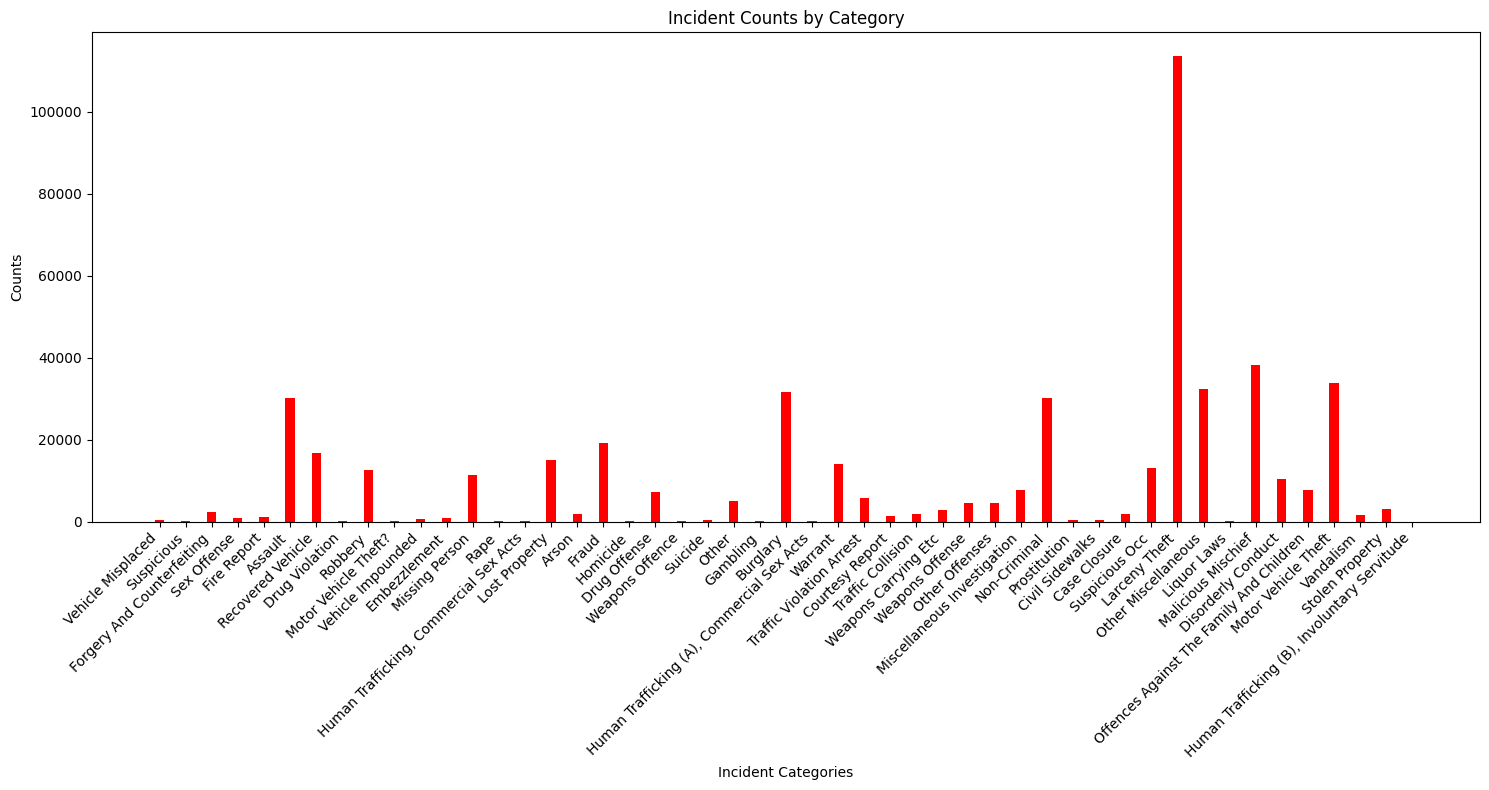

In [ ]:
# Plot classes
import numpy as np
import matplotlib.pyplot as plt

r = data_cleaned.groupBy('Incident Category').count().collect()
categories = [i[0] for i in r]
counts = [i[1] for i in r]

# Setting up the figure and plot
ind = np.arange(len(categories))
width = 0.35

# figure size setting
plt.figure(figsize=(15, 8))

# Plotting the bar chart
plt.bar(ind, counts, width=width, color='r')
plt.xlabel('Incident Categories')
plt.ylabel('Counts')
plt.title('Incident Counts by Category')

# Set y-axis labels as the categories
plt.xticks(ind, categories, rotation=45, ha="right")

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Sample the data to reduce the size to between 100,000 and 500,000 rows.
sampled_data = data_cleaned.sample(False, 100000 / data_cleaned.count(), seed=42)

In [ ]:
# Calculate weights because we have imbalanced classes
# Group by 'Incident Category' and count occurrences
class_counts = sampled_data.groupBy("Incident Category").count()
class_counts.show()

# Calculate the total number of rows in the sampled_data
total = sampled_data.count()

# Calculate the number of unique incident categories
num_classes = class_counts.count()

# Higher weight for less frequent (minority) classes
class_weights = class_counts.withColumn(
    "weight", F.lit(total) / (F.col("count") * num_classes)
)

# Show calculated weights for each category
class_weights.show()

# Join weights back to original data on 'Incident Category'
sampled_data= sampled_data.join(class_weights.select("Incident Category", "weight"), on="Incident Category", how="left")

# Check that 'data_weighted' now has a weight column
sampled_data.show(5)


+--------------------+-----+
|   Incident Category|count|
+--------------------+-----+
|   Vehicle Misplaced|   65|
|          Suspicious|   22|
|Forgery And Count...|  469|
|         Sex Offense|  171|
|         Fire Report|  203|
|             Assault| 6309|
|   Recovered Vehicle| 3484|
|      Drug Violation|   49|
|             Robbery| 2560|
|Motor Vehicle Theft?|   15|
|   Vehicle Impounded|  104|
|        Embezzlement|  164|
|      Missing Person| 2275|
|                Rape|   36|
|Human Trafficking...|    5|
|       Lost Property| 3060|
|               Arson|  397|
|               Fraud| 3924|
|            Homicide|   27|
|        Drug Offense| 1478|
+--------------------+-----+
only showing top 20 rows

+--------------------+-----+-------------------+
|   Incident Category|count|             weight|
+--------------------+-----+-------------------+
|   Vehicle Misplaced|   65|  32.17628205128205|
|          Suspicious|   22|  95.06628787878788|
|Forgery And Count...|  469|  4.4

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

#convert the categrical features into numerical
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in [
 'Incident Day of Week',
 'Report Type Code',
 'Filed Online',
 'Intersection',
 "Incident Category",
 'Police District',
 'Analysis Neighborhood']]

# Create a pipeline to apply the StringIndexer transformations
pipeline = Pipeline(stages=indexers)
data_indexed1 = pipeline.fit(sampled_data).transform(sampled_data)



In [ ]:
data_indexed1.schema["Filed Online_index"].dataType

DoubleType()

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Assemble the numeric columns into a single vector column
assembler = VectorAssembler(inputCols=['Incident Year', 'Incident Day of Week_index',
    'Report Type Code_index', 'Filed Online_index', 'Intersection_index',
     'Police District_index', 'Analysis Neighborhood_index',
    'Latitude', 'Longitude'], outputCol="features")

data_vectorized = assembler.transform(data_indexed1)

In [ ]:
output_df = data_vectorized.select('features', 'Incident Category_index')
output_df.show()

+--------------------+-----------------------+
|            features|Incident Category_index|
+--------------------+-----------------------+
|[2023.0,4.0,0.0,1...|                    9.0|
|[2023.0,5.0,0.0,1...|                    0.0|
|[2023.0,0.0,0.0,0...|                    1.0|
|[2023.0,1.0,0.0,0...|                   17.0|
|[2023.0,5.0,0.0,1...|                    9.0|
|[2023.0,4.0,3.0,0...|                    8.0|
|[2023.0,5.0,2.0,0...|                    0.0|
|[2023.0,6.0,0.0,0...|                    5.0|
|[2023.0,6.0,1.0,0...|                   14.0|
|[2023.0,1.0,0.0,0...|                    3.0|
|[2024.0,1.0,0.0,0...|                   33.0|
|[2023.0,2.0,0.0,0...|                    3.0|
|[2023.0,3.0,0.0,0...|                    4.0|
|[2023.0,0.0,0.0,0...|                   10.0|
|[2022.0,2.0,1.0,0...|                    3.0|
|[2023.0,1.0,1.0,1...|                    0.0|
|[2022.0,2.0,0.0,1...|                    0.0|
|[2024.0,0.0,0.0,0...|                   10.0|
|[2023.0,5.0,

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import *

In [ ]:
# Split into df_train and df_test
df_train, df_test = output_df.randomSplit([0.7, 0.3], seed=40)

In [ ]:
# The total number of rows in df_train and df_test
print(df_train.count())
print(df_test.count())

70278
30112


In [ ]:
# check for unique values
columns_to_check = [
    'Incident Year', 'Incident Day of Week_index', 'Report Type Code_index',
    'Filed Online_index', 'Intersection_index', 'Police District_index',
    'Analysis Neighborhood_index', 'Latitude', 'Longitude'
]

# Display unique values for each column
for col in columns_to_check:
    unique_values = data_indexed1.select(col).distinct().collect()
    print(f"Unique values in '{col}': {[row[col] for row in unique_values]}")
    print(f"Number of unique values in '{col}': {len(unique_values)}\n")


Unique values in 'Incident Year': [2024.0, 2022.0, 2020.0, 2021.0, 2019.0, 2023.0, 2018.0]
Number of unique values in 'Incident Year': 7

Unique values in 'Incident Day of Week_index': [0.0, 1.0, 4.0, 3.0, 2.0, 6.0, 5.0]
Number of unique values in 'Incident Day of Week_index': 7

Unique values in 'Report Type Code_index': [0.0, 1.0, 3.0, 2.0]
Number of unique values in 'Report Type Code_index': 4

Unique values in 'Filed Online_index': [0.0, 1.0]
Number of unique values in 'Filed Online_index': 2

Unique values in 'Intersection_index': [3980.0, 6433.0, 299.0, 496.0, 934.0, 558.0, 692.0, 596.0, 1761.0, 5776.0, 305.0, 769.0, 1051.0, 3597.0, 5858.0, 4066.0, 2734.0, 2815.0, 7313.0, 7171.0, 5983.0, 6765.0, 7115.0, 6454.0, 4142.0, 7554.0, 7782.0, 4800.0, 3901.0, 6653.0, 2862.0, 5360.0, 184.0, 2382.0, 3507.0, 810.0, 576.0, 6305.0, 782.0, 170.0, 720.0, 3345.0, 147.0, 1587.0, 6349.0, 5607.0, 3690.0, 2523.0, 3826.0, 3432.0, 5136.0, 4966.0, 3739.0, 1369.0, 6983.0, 1765.0, 4347.0, 4552.0, 4003.0, 

Latitude and Longitude have too much values that's why we will use kmeans

In [ ]:
from pyspark.ml.functions import vector_to_array

# Convert 'features' vector column to an array column
df_train = df_train.withColumn("dense_features", vector_to_array("features"))
df_test = df_test.withColumn("dense_features", vector_to_array("features"))

In [ ]:
# Extract Latitude and Longitude
df_train = df_train.withColumn("Latitude", col("dense_features")[7])
df_train = df_train.withColumn("Longitude", col("dense_features")[8])

df_test = df_test.withColumn("Latitude", col("dense_features")[7])
df_test = df_test.withColumn("Longitude", col("dense_features")[8])

In [ ]:
from pyspark.ml.clustering import KMeans

# Combine latitude and longitude for clustering
assembler1 = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="location_features")
df_train = assembler1.transform(df_train)
df_test = assembler1.transform(df_test)


In [ ]:
# Apply KMeans clustering
kmeans = KMeans(featuresCol="location_features", k=50, seed=1)
kmeansModel = kmeans.fit(df_train)



In [ ]:
# Assign clusters
df_train = kmeansModel.transform(df_train).withColumnRenamed("prediction", "location_cluster")
df_test = kmeansModel.transform(df_test).withColumnRenamed("prediction", "location_cluster")

In [ ]:
# Convert location_cluster to a double type
df_train = df_train.withColumn("location_cluster_vec", col("location_cluster").cast("double"))
df_test = df_test.withColumn("location_cluster_vec", col("location_cluster").cast("double"))

In [ ]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# If 'dense_features' is an array, convert it to a dense vector
def array_to_vector(array):
    return Vectors.dense(array)

# UDF to convert 'dense_features' into a vector format
array_to_vector_udf = udf(array_to_vector, VectorUDT())

# Apply the UDF to convert 'dense_features' into vector format
df_train = df_test.withColumn("dense_features_vec", array_to_vector_udf("dense_features"))
df_test = df_test.withColumn("dense_features_vec", array_to_vector_udf("dense_features"))




In [ ]:
# Assemble the final features
assembler2 = VectorAssembler(inputCols=["dense_features_vec", "location_cluster_vec"], outputCol="final_features")
df_train = assembler2.transform(df_train).select("final_features", "Incident Category_index")
df_test = assembler2.transform(df_test).select("final_features", "Incident Category_index")

## Random forest model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize and train Random Forest
random_f = RandomForestClassifier(
    labelCol="Incident Category_index",
    featuresCol="final_features",
    numTrees=100,
    maxDepth=20
)

# Train the model
random_f_model = random_f.fit(df_train)

# Transform the test data
test_predic = random_f_model.transform(df_test)

# Evaluator for accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="Incident Category_index",
    predictionCol="prediction",
    metricName="accuracy"
)

# Evaluate the model on training data
train_predic = random_f_model.transform(df_train)
train_accuracy = accuracy_evaluator.evaluate(train_predic)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Evaluate the model on test data
test_accuracy = accuracy_evaluator.evaluate(test_predic)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Additional metrics: Precision, Recall, F1-score
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Incident Category_index",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Incident Category_index",
    predictionCol="prediction",
    metricName="weightedRecall"
)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="Incident Category_index",
    predictionCol="prediction",
    metricName="f1"
)

# Evaluate additional metrics
precision = precision_evaluator.evaluate(test_predic)
recall = recall_evaluator.evaluate(test_predic)
f1_score = f1_evaluator.evaluate(test_predic)

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Train Accuracy: 0.9134
Test Accuracy: 0.9134
Weighted Precision: 0.9146
Weighted Recall: 0.9134
F1-Score: 0.9127


##Feature importances

In [ ]:
# Extract feature importances
# Get feature importances
featureImportances = random_f_model.featureImportances.toArray()

# Map the feature importances back to feature names
featureNames = ['Incident Year', 'Incident Day of Week_index', 'Report Type Code_index',
                 'Filed Online_index', 'Intersection_index', 'Police District_index',
                 'Analysis Neighborhood_index', 'Latitude', 'Longitude',  "location_cluster_vec"]

# Combine feature names and importances into a df
importance_df = pd.DataFrame({
    "Feature": featureNames,
    "Importance": featureImportances
})

# Sort by importance (descending order)
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print(importance_df)


                       Feature  Importance
4           Intersection_index    0.148058
1   Incident Day of Week_index    0.146223
0                Incident Year    0.137284
2       Report Type Code_index    0.116175
8                    Longitude    0.115247
7                     Latitude    0.111046
3           Filed Online_index    0.077822
9         location_cluster_vec    0.060080
6  Analysis Neighborhood_index    0.049394
5        Police District_index    0.038671


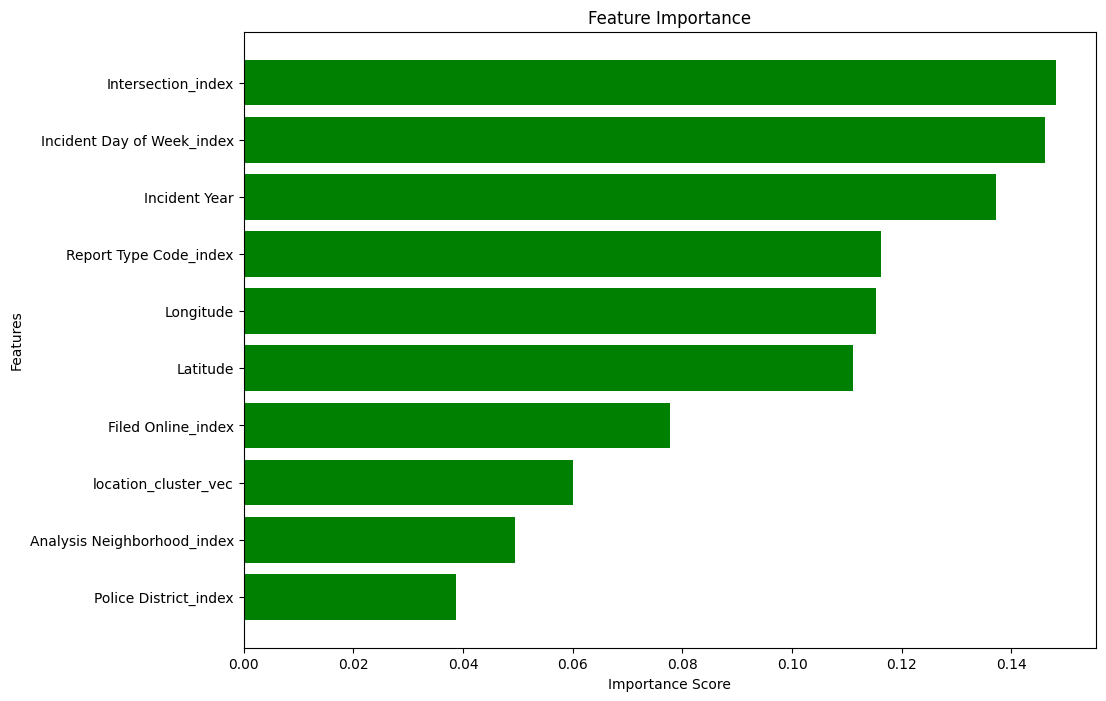

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importances
plt.figure(figsize=(11, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='green')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


##Map

In [ ]:
from pyspark.ml.functions import vector_to_array

# Convert the `final_features` vector to an array in order to access individual values
df_test_with_coords = df_test.withColumn("features_array", vector_to_array(col("final_features")))

df_test_with_coords = df_test_with_coords.withColumn("latitude", col("features_array")[7]) \
                                         .withColumn("longitude", col("features_array")[8])

# Select latitude, longitude, and the prediction
test_predic_with_coords = test_predic.withColumn("features_array", vector_to_array(col("final_features"))) \
                                               .withColumn("latitude", col("features_array")[7]) \
                                               .withColumn("longitude", col("features_array")[8])

# Merge predictions with the location data
predic_df = test_predic_with_coords.select("latitude", "longitude", "prediction").toPandas()

# Check the first few rows
print(predic_df.head())


    latitude   longitude  prediction
0  37.765051 -122.419669         9.0
1  37.765051 -122.419669         9.0
2  37.772831 -122.391374         7.0
3  37.786410 -122.408036        16.0
4  37.786410 -122.408036         0.0


In [ ]:
# Get unique incident types from the data_cleaned
incident_types = data_cleaned.select('Incident Category').distinct().rdd.flatMap(lambda x: x).collect()

# Sort the incident types
incident_types.sort()

# Print the list of incident types in the data_cleaned
print(f"Incident Types in data_cleaned: {incident_types}")


Incident Types in data_cleaned: ['Arson', 'Assault', 'Burglary', 'Case Closure', 'Civil Sidewalks', 'Courtesy Report', 'Disorderly Conduct', 'Drug Offense', 'Drug Violation', 'Embezzlement', 'Fire Report', 'Forgery And Counterfeiting', 'Fraud', 'Gambling', 'Homicide', 'Human Trafficking (A), Commercial Sex Acts', 'Human Trafficking (B), Involuntary Servitude', 'Human Trafficking, Commercial Sex Acts', 'Larceny Theft', 'Liquor Laws', 'Lost Property', 'Malicious Mischief', 'Miscellaneous Investigation', 'Missing Person', 'Motor Vehicle Theft', 'Motor Vehicle Theft?', 'Non-Criminal', 'Offences Against The Family And Children', 'Other', 'Other Miscellaneous', 'Other Offenses', 'Prostitution', 'Rape', 'Recovered Vehicle', 'Robbery', 'Sex Offense', 'Stolen Property', 'Suicide', 'Suspicious', 'Suspicious Occ', 'Traffic Collision', 'Traffic Violation Arrest', 'Vandalism', 'Vehicle Impounded', 'Vehicle Misplaced', 'Warrant', 'Weapons Carrying Etc', 'Weapons Offence', 'Weapons Offense']


In [ ]:
# Create a dictionary that maps the index to the incident name in data_cleaned
incident_type_dict_cleaned = {index: incident_types[index] for index in range(len(incident_types))}

# Print the mapping to verify
for index, name in incident_type_dict_cleaned.items():
    print(f"Index {index} -> Incident Type: {name}")


Index 0 -> Incident Type: Arson
Index 1 -> Incident Type: Assault
Index 2 -> Incident Type: Burglary
Index 3 -> Incident Type: Case Closure
Index 4 -> Incident Type: Civil Sidewalks
Index 5 -> Incident Type: Courtesy Report
Index 6 -> Incident Type: Disorderly Conduct
Index 7 -> Incident Type: Drug Offense
Index 8 -> Incident Type: Drug Violation
Index 9 -> Incident Type: Embezzlement
Index 10 -> Incident Type: Fire Report
Index 11 -> Incident Type: Forgery And Counterfeiting
Index 12 -> Incident Type: Fraud
Index 13 -> Incident Type: Gambling
Index 14 -> Incident Type: Homicide
Index 15 -> Incident Type: Human Trafficking (A), Commercial Sex Acts
Index 16 -> Incident Type: Human Trafficking (B), Involuntary Servitude
Index 17 -> Incident Type: Human Trafficking, Commercial Sex Acts
Index 18 -> Incident Type: Larceny Theft
Index 19 -> Incident Type: Liquor Laws
Index 20 -> Incident Type: Lost Property
Index 21 -> Incident Type: Malicious Mischief
Index 22 -> Incident Type: Miscellaneou

In [ ]:

predic_df = test_predic_with_coords.select("latitude", "longitude", "prediction").toPandas()

# Map predicted indices to incident type names
predic_df['predicted_incident_type'] = predic_df['prediction'].apply(
    lambda x: incident_type_dict_cleaned.get(x, "Unknown Incident Type")
)

# Display the predictions with incident type names
print(predic_df[['prediction', 'predicted_incident_type']].head())



   prediction                       predicted_incident_type
0         9.0                                  Embezzlement
1         9.0                                  Embezzlement
2         7.0                                  Drug Offense
3        16.0  Human Trafficking (B), Involuntary Servitude
4         0.0                                         Arson


In [ ]:
# Create the map to display incident types
import folium
from folium.plugins import MarkerCluster
from IPython.display import IFrame

# Create a base map centered on San Francisco
sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12, tiles="CartoDB positron")

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(sf_map)

# Add markers to the cluster
for _, row in predic_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Incident Type: {row['predicted_incident_type']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Save the map
sf_map.save("sf_incident_map.html")

# Display the map in Google Colab
display(IFrame("sf_incident_map.html", width=700, height=500))

